<a href="https://colab.research.google.com/github/A-ZtCode/-TMT-Alpha-Strategy-Volatility-Adjusted-Momentum-and-Earnings-Revisions/blob/main/TMT_Alpha_Strategy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Install libraries
!pip install yfinance  --quiet

# import required packages
import pandas as pd
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from datetime import date, timedelta
today = date.today()


In [2]:
# raw_data = yf.download(tickers, start="2022-01-01", end="2024-12-31")
# print(raw_data.columns.levels)

In [3]:
# Define TMT universe

tickers = ['AAPL', 'MSFT', 'GOOG', 'META', 'NFLX', 'AMZN', 'DIS', 'CRM', 'ADBE', 'VZ']

# Download Adjusted close prices (last 2 years)
data = yf.download(tickers, start="2022-01-01", end="2024-12-31")["Close"]

# Preview the structure of the downloaded data
display(data.head())
display(data.tail())

/tmp/ipython-input-3-1838130896.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers, start="2022-01-01", end="2024-12-31")["Close"]
[*********************100%***********************]  10 of 10 completed


Ticker,AAPL,ADBE,AMZN,CRM,DIS,GOOG,META,MSFT,NFLX,VZ
Date,,,,,,,,,,
2022-01-03,178.645660,564.369995,170.404495,253.240982,154.189560,144.217239,336.692902,325.038055,597.369995,41.324299
2022-01-04,176.378357,554.000000,167.522003,246.073761,153.176422,143.563141,334.693817,319.464600,591.150024,42.135975
2022-01-05,171.686691,514.429993,164.356995,225.692368,152.645294,136.840103,322.401306,307.201019,567.520020,42.569389
2022-01-06,168.820679,514.119995,163.253998,227.159500,154.327240,136.738220,330.646027,304.773560,553.289978,42.364506
2022-01-07,168.987549,510.700012,162.554001,226.326797,155.242020,136.194931,329.979706,304.928894,541.059998,43.257732


Ticker,AAPL,ADBE,AMZN,CRM,DIS,GOOG,META,MSFT,NFLX,VZ
Date,,,,,,,,,,
2024-12-23,254.655716,446.739990,225.059998,341.820038,110.926964,195.531952,598.856018,433.583038,911.450012,38.009636
2024-12-24,257.578674,447.940002,229.050003,343.345184,112.082031,197.108246,606.742920,437.647400,932.119995,37.876400
2024-12-26,258.396667,450.160004,227.050003,340.643738,112.072083,196.639343,602.350220,436.432068,924.140015,38.028667
2024-12-27,254.974930,446.480011,223.750000,337.384064,111.076332,193.586487,598.816101,428.881104,907.549988,37.990597
2024-12-30,251.593079,445.799988,221.300003,334.682587,110.329514,192.239655,590.260254,423.202911,900.429993,37.686066


# **Section 3: Create a Simulated 'Earnings Revision' Signal**

## **What is a “Quant Signal”?**
A signal is just a number or score that tries to predict future performance of a stock.

We created a very basic one using:

signal = data.pct_change(5)

This calculates how much each stock has moved in the past 5 trading days.

This is a placeholder for a real signal like:

*   Analysts upgrading their earnings estimates
*   Surge in search or news volume
*   Strong recent momentum over months

Right now, we’re using 5-day past return as a quick and simple proxy.

Once we generate signals, we rank the stocks every day based on their score:

signal_ranked = signal.rank(axis=1, ascending=False)

Use 5-day returns as a placeholder for now

In [4]:
# Simulate revision signal using 5-day price change
signal = data.pct_change(5).dropna()

# Rank each date's stocks by this "signal"
signal_ranked = signal.rank(axis=1, ascending=False)

# Preview the signal
display(signal_ranked.head())
display(signal_ranked.tail())

Ticker,AAPL,ADBE,AMZN,CRM,DIS,GOOG,META,MSFT,NFLX,VZ
Date,,,,,,,,,,
2022-01-10,6.0,8.0,5.0,10.0,2.0,4.0,3.0,7.0,9.0,1.0
2022-01-11,5.0,8.0,4.0,9.0,2.0,6.0,3.0,7.0,10.0,1.0
2022-01-12,8.0,2.0,7.0,1.0,5.0,3.0,4.0,6.0,10.0,9.0
2022-01-13,4.0,3.0,7.0,5.0,6.0,1.0,8.0,9.0,10.0,2.0
2022-01-14,4.0,2.0,6.0,3.0,10.0,1.0,5.0,7.0,9.0,8.0


Ticker,AAPL,ADBE,AMZN,CRM,DIS,GOOG,META,MSFT,NFLX,VZ
Date,,,,,,,,,,
2024-12-23,1.0,6.0,7.0,9.0,2.0,4.0,10.0,8.0,3.0,5.0
2024-12-24,1.0,6.0,5.0,7.0,4.0,3.0,8.0,10.0,2.0,9.0
2024-12-26,1.0,5.0,4.0,6.0,7.0,3.0,8.0,9.0,2.0,10.0
2024-12-27,1.0,3.0,7.0,5.0,8.0,2.0,4.0,10.0,6.0,9.0
2024-12-30,5.0,3.0,8.0,9.0,7.0,2.0,1.0,10.0,6.0,4.0


# **Section 4: Calculate 5-Day Forward Returns**

## **What is a “Forward Return”?**
We then check what happened to the stock after the signal date:

forward_returns = data.pct_change(5).shift(-5)

This tells us:

“If I picked a stock today based on its signal, what return would I get over the next 5 days?”

It’s how we measure the accuracy of the signal.

In [5]:
# Calculate 5-day forward returns for each stock
forward_returns = data.pct_change(5).shift(-5)
forward_returns = forward_returns.loc[signal.index] # Align dates

# Preview the forward returns
display(forward_returns.tail())

Ticker,AAPL,ADBE,AMZN,CRM,DIS,GOOG,META,MSFT,NFLX,VZ
Date,,,,,,,,,,
2024-12-23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-12-24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-12-26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-12-27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-12-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# **Section 5: Group by Quantiles and Compare Returns**

## **What is a “Quantile”?**

Then, we split them into 5 groups (quantiles):

quantiles = signal_ranked.apply(lambda x: pd.qcut(x, q=5, labels=False), axis=1)

*   Quantile 0 = Top 20% → stocks with the strongest signal
*   Quantile 4 = Bottom 20% → weakest signal

This lets us test if top-scoring stocks go on to do better than bottom-scoring ones.



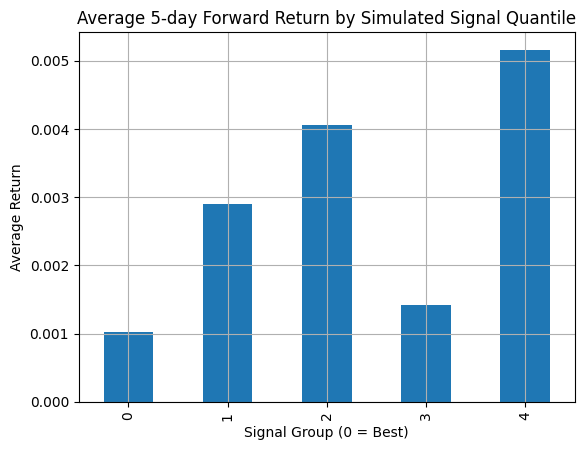

In [6]:
# Bin stocks into 5 groups (quantiles) per day based on signal rank
quantiles = signal_ranked.apply(lambda x: pd.qcut(x, q=5, labels=False), axis=1)

# Group forward returnns by quantile
avg_returns_by_quantile = pd.DataFrame()

for q in range(5):
  mask = quantiles == q
  returns_q = forward_returns[mask]
  avg_returns_by_quantile[q] = returns_q.mean(axis=1)

# Plot the average returns by signal group
avg_returns_by_quantile.mean().plot(kind='bar')
plt.title('Average 5-day Forward Return by Simulated Signal Quantile')
plt.xlabel('Signal Group (0 = Best)')
plt.ylabel('Average Return')
plt.grid(True)
plt.show()

This showed the average 5-day return for each signal group:



*   If Quantile 0 is higher than Quantile 4, that’s good.
*   If it's reversed or flat, the signal might be weak or need tweaking.



# **Section 6: Long/Short Portfolio Simulation**

### **What is a Long/Short Strategy?**
This is a classic hedge fund idea:

* You go long (buy) the best stocks → Quantile 0

* You go short (bet against) the worst → Quantile 4

You’re not trying to guess the whole market — just bet that the good will beat the bad.

This gives you “market-neutral” exposure — you're not exposed to the whole market, just the relative difference.

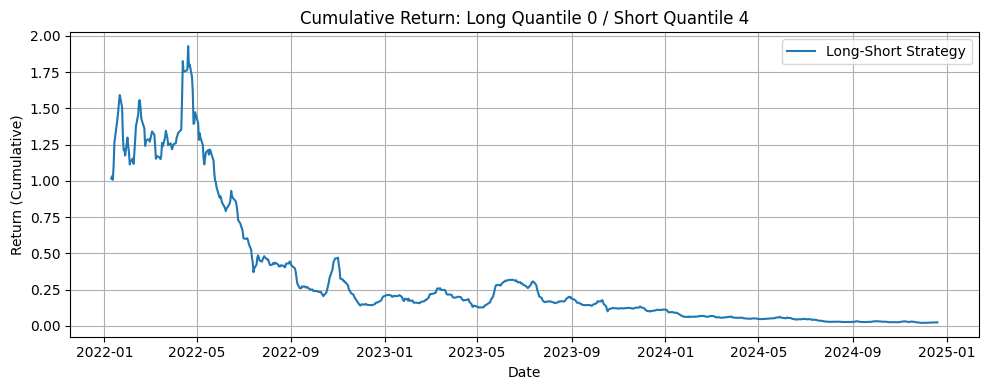

In [7]:
# Calculate average daily long and short returns

long_returns = forward_returns[quantiles == 0].mean(axis=1)
short_returns = forward_returns[quantiles == 4].mean(axis=1)

# Combine into long-short
long_short_returns = long_returns - short_returns

# Drop missing values
long_short_returns = long_short_returns.dropna()

# Cumulative return over time
cumulative_return = (1 + long_short_returns).cumprod()

# Plot
plt.figure(figsize=(10, 4))
plt.plot(cumulative_return, label='Long-Short Strategy')
plt.title('Cumulative Return: Long Quantile 0 / Short Quantile 4')
plt.xlabel('Date')
plt.ylabel('Return (Cumulative)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

## **How was it simulated?**

We averaged returns of Quantile 0 and 4 each day:

long_returns = forward_returns[quantiles == 0].mean(axis=1)
short_returns = forward_returns[quantiles == 4].mean(axis=1)

Then we calculated the daily strategy return:

long_short_returns = long_returns - short_returns

And then I plotted how the money would grow over time:

(1 + long_short_returns).cumprod()


This gave the cumulative return curve — showing how well the signal-driven strategy did.

The strategy initially performed well (early 2022), peaking around 1.8× return.

Then it declined steadily, ending close to or even below 1.0 (flat or loss).

That suggests the current signal (5-day return) doesn't hold strong predictive power long-term — which is expected for a simple simulation.

# **Improve the signal  (use 20-day trend instead of 5-day noise)**

## **Why 20-Day Momentum?**

The 5-day return was noisy — it often reflects random short-term moves.

But 20-day (1-month) return:

* Captures a more stable trend

* Is used in many real-world quant models

* Is especially helpful in trend-following strategies

In [8]:
# Simulate revision signal using 20-day price change
signal = data.pct_change(20).dropna()

# Rank each date's stocks by this "signal"
signal_ranked = signal.rank(axis=1, ascending=False)

# Preview the signal
display(signal_ranked.head())
display(signal_ranked.tail())

Ticker,AAPL,ADBE,AMZN,CRM,DIS,GOOG,META,MSFT,NFLX,VZ
Date,,,,,,,,,,
2022-02-01,2.0,4.0,9.0,8.0,7.0,3.0,5.0,6.0,10.0,1.0
2022-02-02,3.0,4.0,9.0,8.0,7.0,1.0,5.0,6.0,10.0,2.0
2022-02-03,4.0,3.0,8.0,6.0,7.0,1.0,9.0,5.0,10.0,2.0
2022-02-04,3.0,4.0,6.0,7.0,8.0,1.0,10.0,5.0,9.0,2.0
2022-02-07,2.0,3.0,5.0,7.0,8.0,1.0,10.0,6.0,9.0,4.0


Ticker,AAPL,ADBE,AMZN,CRM,DIS,GOOG,META,MSFT,NFLX,VZ
Date,,,,,,,,,,
2024-12-23,3.0,10.0,2.0,7.0,8.0,1.0,4.0,5.0,6.0,9.0
2024-12-24,3.0,10.0,2.0,7.0,8.0,1.0,5.0,6.0,4.0,9.0
2024-12-26,2.0,10.0,3.0,7.0,8.0,1.0,5.0,6.0,4.0,9.0
2024-12-27,2.0,10.0,3.0,6.0,8.0,1.0,4.0,7.0,5.0,9.0
2024-12-30,3.0,10.0,2.0,5.0,8.0,1.0,4.0,7.0,6.0,9.0


In [9]:
# Calculate 5-day forward returns for each stock
forward_returns = data.pct_change(5).shift(-5)
forward_returns = forward_returns.loc[signal.index] # Align dates

# Preview the forward returns
display(forward_returns.tail())

Ticker,AAPL,ADBE,AMZN,CRM,DIS,GOOG,META,MSFT,NFLX,VZ
Date,,,,,,,,,,
2024-12-23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-12-24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-12-26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-12-27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-12-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


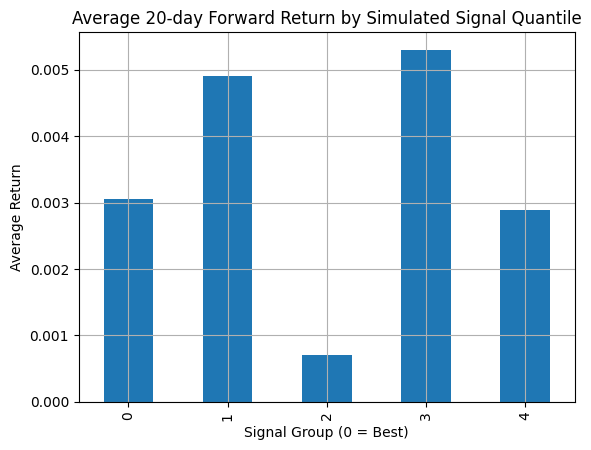

In [10]:
# Bin stocks into 5 groups (quantiles) per day based on signal rank
quantiles = signal_ranked.apply(lambda x: pd.qcut(x, q=5, labels=False), axis=1)

# Group forward returnns by quantile
avg_returns_by_quantile = pd.DataFrame()

for q in range(5):
  mask = quantiles == q
  returns_q = forward_returns[mask]
  avg_returns_by_quantile[q] = returns_q.mean(axis=1)

# Plot the average returns by signal group
avg_returns_by_quantile.mean().plot(kind='bar')
plt.title('Average 20-day Forward Return by Simulated Signal Quantile')
plt.xlabel('Signal Group (0 = Best)')
plt.ylabel('Average Return')
plt.grid(True)
plt.show()

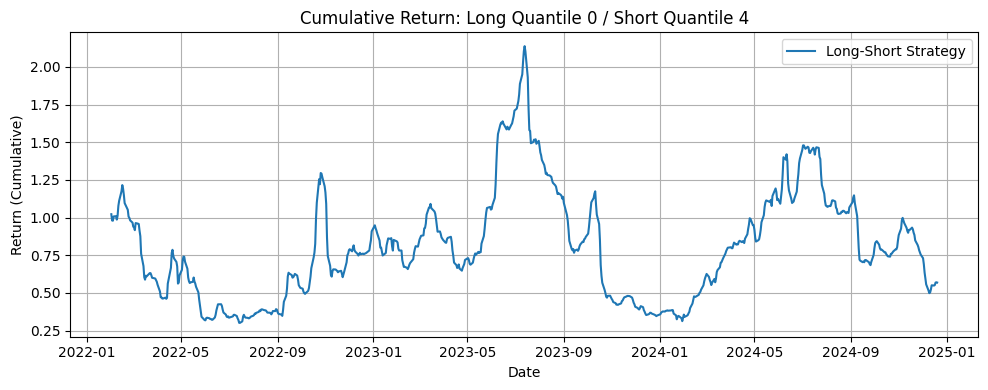

In [11]:
# Calculate average daily long and short returns

long_returns = forward_returns[quantiles == 0].mean(axis=1)
short_returns = forward_returns[quantiles == 4].mean(axis=1)

# Combine into long-short
long_short_returns = long_returns - short_returns

# Drop missing values
long_short_returns = long_short_returns.dropna()

# Cumulative return over time
cumulative_return = (1 + long_short_returns).cumprod()

# Plot
plt.figure(figsize=(10, 4))
plt.plot(cumulative_return, label='Long-Short Strategy')
plt.title('Cumulative Return: Long Quantile 0 / Short Quantile 4')
plt.xlabel('Date')
plt.ylabel('Return (Cumulative)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

## **1. Sharpe Ratio – “Is this return worth the risk?”**
The Sharpe Ratio measures:

    “How much extra return am I getting for each unit of risk I’m taking?”

It’s calculated as:


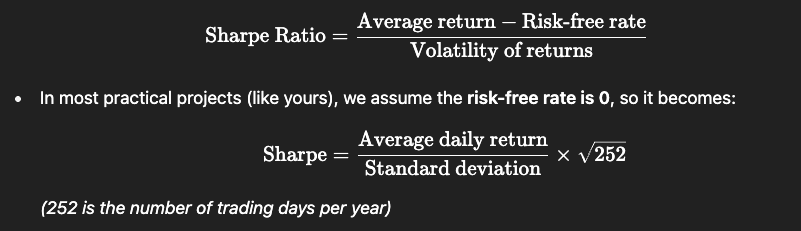

**Example:**
If the strategy makes +15% annually with high volatility:

* Sharpe might be 1.0 (decent)

If it makes +15% annually but is very smooth:

* Sharpe might be 2.5+ (great!)

If it makes +10% but is super risky:

* Sharpe might be 0.3 or even negative (bad)


    What’s a “good” Sharpe?
    Sharpe Ratio	      Meaning
    > 2.0	             Excellent
    1.0 – 2.0	         Good
    0.5 – 1.0	         Meh / could improve
    < 0.5	             Weak (too volatile for the return)

The Sharpe ratio: 0.06 → almost flat = very risky with little net reward

## **Max Drawdown – “How bad did it get?”**

Max Drawdown is the worst loss from a peak to a low during the strategy’s history.

    It means the biggest crash you would have experienced.

**Example**

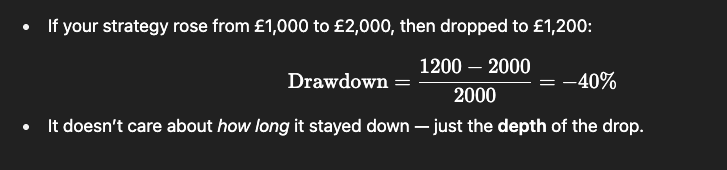

    What’s a “good” drawdown?
    Max Drawdown	Meaning
    < 10%	       Very safe
    10–20%	      Acceptable
    20–40%	      Risky
    > 50%	       Very dangerous

# **Compare strategy vs XLK**

In [12]:
# --- Benchmark: XLK ETF (Technology Select Sector) --------------------------
xlk = yf.download('XLK', start="2022-01-01", end="2024-12-31")['Close']

# Turn XLK prices into a cumulative-return series
xlk_return = (1 + xlk.pct_change().dropna()).cumprod()

# Make sure XLK dates match the strategy dates
xlk_return = xlk_return.loc[cumulative_return.index]

/tmp/ipython-input-12-3628749240.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  xlk = yf.download('XLK', start="2022-01-01", end="2024-12-31")['Close']
[*********************100%***********************]  1 of 1 completed


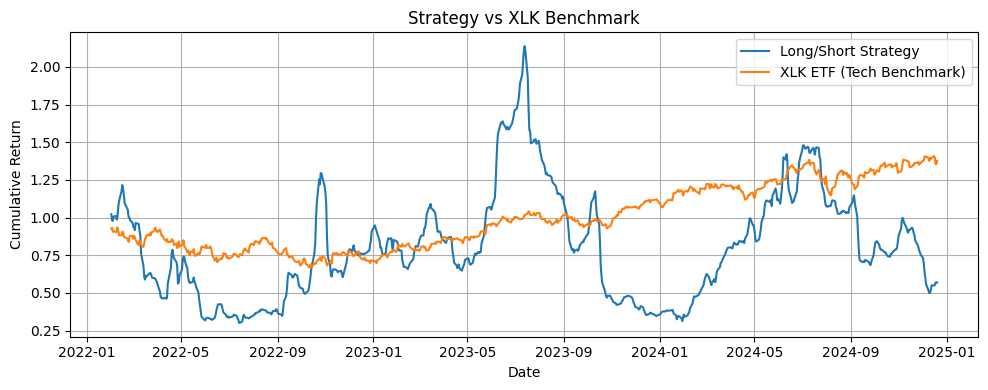

In [13]:
# --- Plot strategy vs XLK ----------------------------------------------------
plt.figure(figsize=(10, 4))
plt.plot(cumulative_return, label='Long/Short Strategy')
plt.plot(xlk_return, label='XLK ETF (Tech Benchmark)')
plt.title('Strategy vs XLK Benchmark')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

## **Chart – Strategy vs XLK Benchmark**

Orange line (XLK):

Consistent upward trend. This is typical of a passive tech ETF, reflecting strong long-term performance of the tech sector.

Blue line (Long/Short Strategy):

High peaks but also deep drops. The signal does sometimes catch momentum (e.g. mid-2023), but lacks stability.


# **Add Sharpe Ratio + Max Drawdown**

In [14]:
# Daily long-short returns already stored in long_short_returns
sharpe = long_short_returns.mean() / long_short_returns.std() * np.sqrt(252)

# Max draw-down
cumulative = (1 + long_short_returns).cumprod()
drawdown = cumulative / cumulative.cummax() - 1
max_drawdown = drawdown.min()

print(f"Sharpe Ratio: {sharpe:.2f}")
print(f"Max Draw-down: {max_drawdown:.2%}")

Sharpe Ratio: 0.06
Max Draw-down: -85.36%


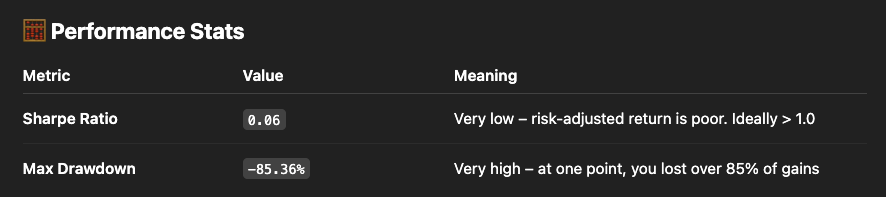

# **Improve Existing Signal**

**Goal:**
Make the current 20-day momentum signal more stable and realistic — by adjusting it for volatility.

Why?

    
A stock that gained 10% calmly is more reliable than one that gained 10% while jumping all over the place.

## **Plan: Create a volatility-adjusted momentum signal**

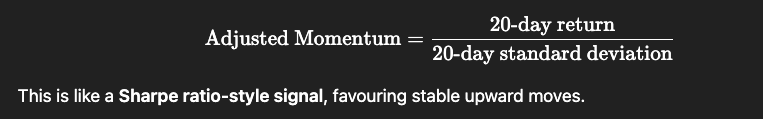


In [15]:
# Replace Signal Line

# 20-day return
momentum = data.pct_change(20)

# 20-day rolling volatility (standard deviation)
volatility = data.pct_change().rolling(20).std()

# Volatility-adjusted momentum
signal = (momentum / volatility).dropna()

In [16]:
# Calculate 5-day forward returns for each stock
forward_returns = data.pct_change(5).shift(-5)
forward_returns = forward_returns.loc[signal.index] # Align dates

# Preview the forward returns
display(forward_returns.tail())

Ticker,AAPL,ADBE,AMZN,CRM,DIS,GOOG,META,MSFT,NFLX,VZ
Date,,,,,,,,,,
2024-12-23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-12-24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-12-26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-12-27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-12-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


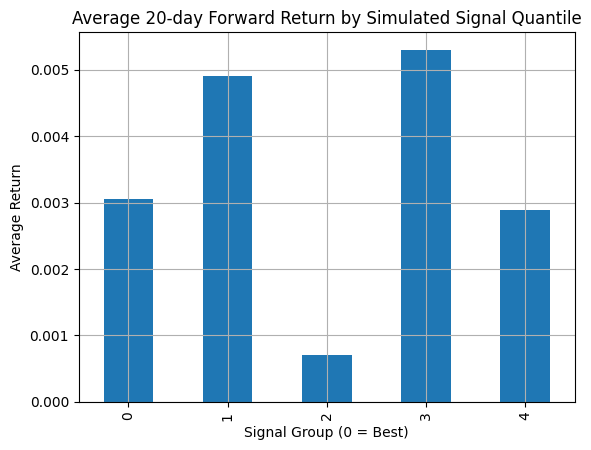

In [17]:
# Bin stocks into 5 groups (quantiles) per day based on signal rank
quantiles = signal_ranked.apply(lambda x: pd.qcut(x, q=5, labels=False), axis=1)

# Group forward returnns by quantile
avg_returns_by_quantile = pd.DataFrame()

for q in range(5):
  mask = quantiles == q
  returns_q = forward_returns[mask]
  avg_returns_by_quantile[q] = returns_q.mean(axis=1)

# Plot the average returns by signal group
avg_returns_by_quantile.mean().plot(kind='bar')
plt.title('Average 20-day Forward Return by Simulated Signal Quantile')
plt.xlabel('Signal Group (0 = Best)')
plt.ylabel('Average Return')
plt.grid(True)
plt.show()

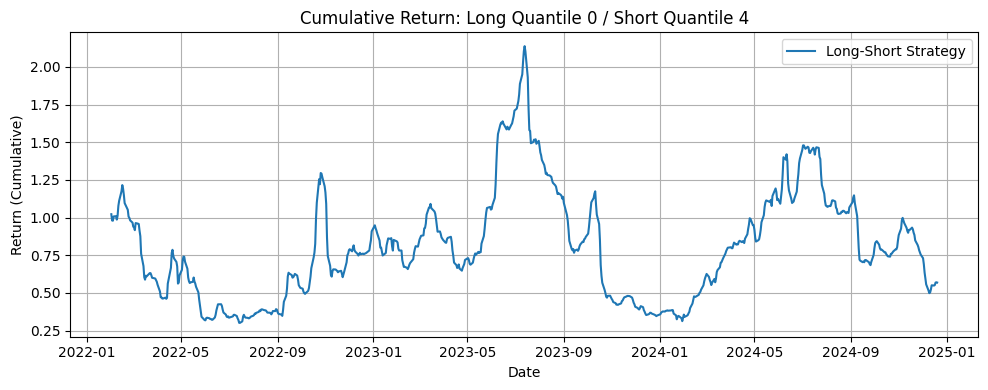

In [18]:
# Calculate average daily long and short returns

long_returns = forward_returns[quantiles == 0].mean(axis=1)
short_returns = forward_returns[quantiles == 4].mean(axis=1)

# Combine into long-short
long_short_returns = long_returns - short_returns

# Drop missing values
long_short_returns = long_short_returns.dropna()

# Cumulative return over time
cumulative_return = (1 + long_short_returns).cumprod()

# Plot
plt.figure(figsize=(10, 4))
plt.plot(cumulative_return, label='Long-Short Strategy')
plt.title('Cumulative Return: Long Quantile 0 / Short Quantile 4')
plt.xlabel('Date')
plt.ylabel('Return (Cumulative)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [19]:
# Check sample signal values
display(signal.iloc[-5:])  # Last few rows


Ticker,AAPL,ADBE,AMZN,CRM,DIS,GOOG,META,MSFT,NFLX,VZ
Date,,,,,,,,,,
2024-12-23,12.425027,-3.642123,7.833556,0.121453,-3.882654,8.174211,3.965323,3.469691,0.956923,-6.356010
2024-12-24,12.321929,-3.915952,7.640646,0.551667,-2.902372,7.724143,4.095216,3.859374,5.465612,-9.157302
2024-12-26,11.607225,-4.126290,5.365393,-0.102255,-2.390697,7.180253,2.839583,1.988901,4.134327,-9.848100
2024-12-27,9.145893,-3.793306,5.022651,0.915110,-6.275882,6.135416,2.943754,1.452734,2.293610,-9.988043
2024-12-30,6.105321,-3.949651,3.646569,0.634207,-6.937811,5.845482,1.604646,0.255265,1.023637,-10.662271


In [20]:
# Optional: compare original 20-day return to adjusted
raw_momentum = data.pct_change(20).dropna()
adj_momentum = (raw_momentum / data.pct_change().rolling(20).std()).dropna()

display(raw_momentum.iloc[-1])
display(adj_momentum.iloc[-1])


,2024-12-30
Ticker,
AAPL,0.062655
ADBE,-0.135929
AMZN,0.064505
CRM,0.018586
DIS,-0.052601
GOOG,0.131495
META,0.030291
MSFT,0.003235
NFLX,0.015358


,2024-12-30
Ticker,
AAPL,6.105321
ADBE,-3.949651
AMZN,3.646569
CRM,0.634207
DIS,-6.937811
GOOG,5.845482
META,1.604646
MSFT,0.255265
NFLX,1.023637


# **Create Simulated Earnings Revision Signal**

## **Simulate a daily “earnings revision score” for each stock.**

**Assumptions:**
* Positive scores = analysts are revising earnings upward

* Negative scores = analysts are cutting earnings forecasts

* Randomised for learning, but structured enough to feel real

In [21]:
# Simulate earnings revision signal (structured random for learning)
np.random.seed(42)  # For reproducibility
revision_signal = pd.DataFrame(
    np.random.normal(loc=0, scale=1, size=signal.shape),
    index=signal.index,
    columns=signal.columns
)

# Preview
display(revision_signal.tail())

Ticker,AAPL,ADBE,AMZN,CRM,DIS,GOOG,META,MSFT,NFLX,VZ
Date,,,,,,,,,,
2024-12-23,-1.717672,0.236142,0.904962,-0.225807,1.436430,-0.703916,-1.054704,-0.067230,-0.082593,0.769969
2024-12-24,-0.774963,1.368094,1.966917,-0.039144,1.249710,-1.056497,1.075222,1.047276,0.863437,-0.015563
2024-12-26,-2.954249,-0.641727,-0.625916,-0.978255,0.122243,-0.418963,-0.824612,-1.058800,-0.715513,1.121499
2024-12-27,-0.661025,-0.514939,-0.456698,0.338994,0.456249,-3.044657,1.021635,1.436368,-1.050187,-0.972298
2024-12-30,-0.450253,-0.756004,0.223927,-1.946525,-1.117928,1.539197,-0.928220,1.243428,0.355338,-1.809268


In [22]:
# Use a simple weighted average
# Combine momentum and revision into final alpha score
final_signal = 0.6 * signal + 0.4 * revision_signal


In [23]:
# Rank each date's stocks by this "signal"
signal_ranked = final_signal.rank(axis=1, ascending=False)

# Preview the signal
display(signal_ranked.head())
display(signal_ranked.tail())

Ticker,AAPL,ADBE,AMZN,CRM,DIS,GOOG,META,MSFT,NFLX,VZ
Date,,,,,,,,,,
2022-02-01,3.0,4.0,10.0,5.0,8.0,6.0,2.0,7.0,9.0,1.0
2022-02-02,3.0,4.0,7.0,8.0,10.0,1.0,6.0,5.0,9.0,2.0
2022-02-03,2.0,4.0,10.0,6.0,8.0,1.0,9.0,5.0,7.0,3.0
2022-02-04,4.0,1.0,5.0,6.0,8.0,2.0,9.0,7.0,10.0,3.0
2022-02-07,1.0,3.0,4.0,6.0,10.0,2.0,9.0,5.0,8.0,7.0


Ticker,AAPL,ADBE,AMZN,CRM,DIS,GOOG,META,MSFT,NFLX,VZ
Date,,,,,,,,,,
2024-12-23,1.0,9.0,2.0,7.0,8.0,3.0,5.0,4.0,6.0,10.0
2024-12-24,1.0,9.0,2.0,7.0,8.0,3.0,5.0,6.0,4.0,10.0
2024-12-26,1.0,9.0,3.0,7.0,8.0,2.0,5.0,6.0,4.0,10.0
2024-12-27,1.0,8.0,2.0,7.0,9.0,3.0,4.0,5.0,6.0,10.0
2024-12-30,2.0,8.0,3.0,7.0,9.0,1.0,6.0,5.0,4.0,10.0


In [24]:
# Calculate 5-day forward returns for each stock
forward_returns = data.pct_change(5).shift(-5)
forward_returns = forward_returns.loc[signal.index] # Align dates

# Preview the forward returns
display(forward_returns.tail())

Ticker,AAPL,ADBE,AMZN,CRM,DIS,GOOG,META,MSFT,NFLX,VZ
Date,,,,,,,,,,
2024-12-23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-12-24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-12-26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-12-27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-12-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


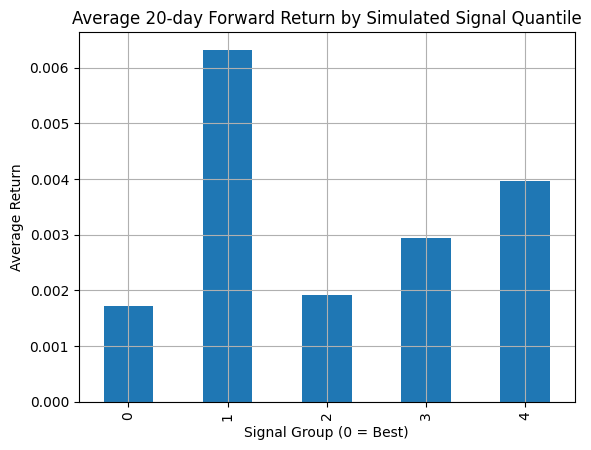

In [25]:
# Bin stocks into 5 groups (quantiles) per day based on signal rank
quantiles = signal_ranked.apply(lambda x: pd.qcut(x, q=5, labels=False), axis=1)

# Group forward returnns by quantile
avg_returns_by_quantile = pd.DataFrame()

for q in range(5):
  mask = quantiles == q
  returns_q = forward_returns[mask]
  avg_returns_by_quantile[q] = returns_q.mean(axis=1)

# Plot the average returns by signal group
avg_returns_by_quantile.mean().plot(kind='bar')
plt.title('Average 20-day Forward Return by Simulated Signal Quantile')
plt.xlabel('Signal Group (0 = Best)')
plt.ylabel('Average Return')
plt.grid(True)
plt.show()

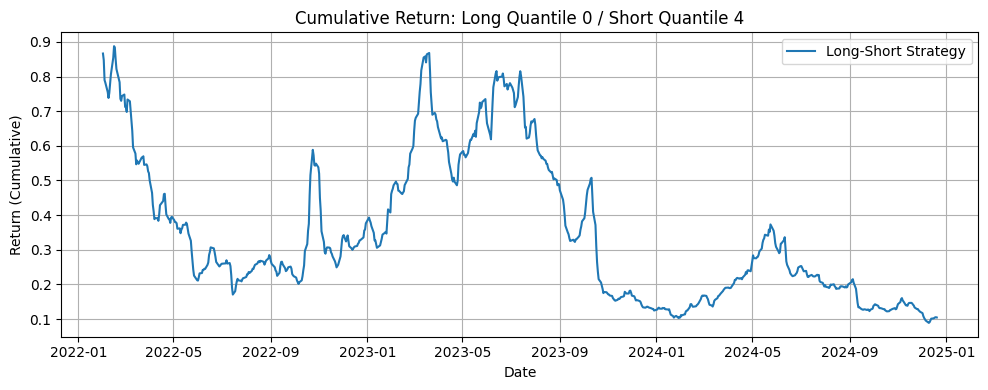

In [26]:
# Calculate average daily long and short returns

long_returns = forward_returns[quantiles == 0].mean(axis=1)
short_returns = forward_returns[quantiles == 4].mean(axis=1)

# Combine into long-short
long_short_returns = long_returns - short_returns

# Drop missing values
long_short_returns = long_short_returns.dropna()

# Cumulative return over time
cumulative_return = (1 + long_short_returns).cumprod()

# Plot
plt.figure(figsize=(10, 4))
plt.plot(cumulative_return, label='Long-Short Strategy')
plt.title('Cumulative Return: Long Quantile 0 / Short Quantile 4')
plt.xlabel('Date')
plt.ylabel('Return (Cumulative)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [27]:
# Daily long-short returns already stored in long_short_returns
sharpe = long_short_returns.mean() / long_short_returns.std() * np.sqrt(252)

# Max draw-down
cumulative = (1 + long_short_returns).cumprod()
drawdown = cumulative / cumulative.cummax() - 1
max_drawdown = drawdown.min()

print(f"Sharpe Ratio: {sharpe:.2f}")
print(f"Max Draw-down: {max_drawdown:.2%}")

Sharpe Ratio: -0.87
Max Draw-down: -89.98%


## Test Different Signal Weight Combinations

We'll test how different blends of:

- Momentum (vol-adjusted)

- Earnings Revisions (simulated)

affect the long/short strategy performance.


### What will be done:
1. Loop through different weights (e.g. 90% momentum / 10% revision, then 80/20, etc.)

2. For each combination:

  - Blend the signal
  - Rank stocks
  - Simulate long/short strategy
  - Calculate Sharpe ratio

3. Plot the Sharpe ratio for each weighting



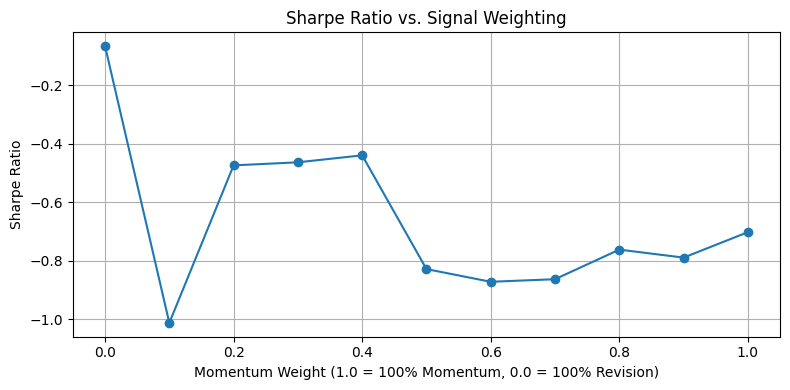

📌 Best Sharpe Ratio: -0.07 at Momentum Weight: 0.0


In [28]:
# Store results
results = []

# Try weights from 0.0 to 1.0 (0% momentum → 100% momentum)
for weight in np.arange(0.0, 1.1, 0.1):
    momentum_weight = weight
    revision_weight = 1 - weight

    # Blended signal
    blended_signal = momentum_weight * signal + revision_weight * revision_signal

    # Rank
    ranked = blended_signal.rank(axis=1, ascending=False)

    # Quantile assignment
    quantiles = ranked.apply(lambda x: pd.qcut(x, q=5, labels=False), axis=1)

    # Forward returns
    forward_returns = data.pct_change(5).shift(-5).loc[blended_signal.index]

    # Long = Q0, Short = Q4
    long_returns = forward_returns[quantiles == 0].mean(axis=1)
    short_returns = forward_returns[quantiles == 4].mean(axis=1)
    long_short_returns = (long_returns - short_returns).dropna()

    # Sharpe ratio
    sharpe = long_short_returns.mean() / long_short_returns.std() * np.sqrt(252)

    results.append((momentum_weight, sharpe))

# Convert to DataFrame
results_df = pd.DataFrame(results, columns=['Momentum Weight', 'Sharpe Ratio'])

# Plot
plt.figure(figsize=(8, 4))
plt.plot(results_df['Momentum Weight'], results_df['Sharpe Ratio'], marker='o')
plt.title("Sharpe Ratio vs. Signal Weighting")
plt.xlabel("Momentum Weight (1.0 = 100% Momentum, 0.0 = 100% Revision)")
plt.ylabel("Sharpe Ratio")
plt.grid(True)
plt.tight_layout()
plt.show()

# Show best performer
best = results_df.loc[results_df['Sharpe Ratio'].idxmax()]
print(f"📌 Best Sharpe Ratio: {best['Sharpe Ratio']:.2f} at Momentum Weight: {best['Momentum Weight']:.1f}")


### Interpretation of Results

The chart and output show:

 - Best Sharpe Ratio: -0.07 at Momentum Weight: 0.0

This means the best performance came when the signal was based 100% on the simulated earnings revision, and not at all on momentum.

That tells two key things:

1. Momentum (even volatility-adjusted) isn’t contributing much alpha in this setup.

2. Revision signal alone performs best — even though the overall Sharpe is still negative, it's the least bad.

## **Build Final Strategy Using Only Revisions**

### Step: Create revision_scores from 5-day returns

In [29]:
# Step 1: Simulate earnings revision signal using 5-day return
revision_signal = data.pct_change(5).dropna()

# Step 2: Rank each date's stocks by revision signal (higher = more upward revision)
revision_scores = revision_signal.rank(axis=1, ascending=False)


### Step 1: Score Stocks Using Only Revision Signal

In [30]:
# Step 1: Rank stocks into quantiles based on revision signal
quantiles = revision_scores.rank(axis=1, method='first', ascending=False)
quantiles = (quantiles / quantiles.shape[1] * 5).astype(int)

### Step 2: Create Forward Returns

In [31]:
# Calculate forward 1-day returns
forward_returns = data.pct_change().shift(-1)


### Step 3: Simulate Long/Short Strategy

In [32]:
# Long top quantile (highest revision), short bottom quantile (lowest revision)
long_returns = forward_returns[quantiles == 0].mean(axis=1)
short_returns = forward_returns[quantiles == 4].mean(axis=1)

long_short_returns = long_returns - short_returns
long_short_returns = long_short_returns.dropna()


### Step 4: Plot Performance

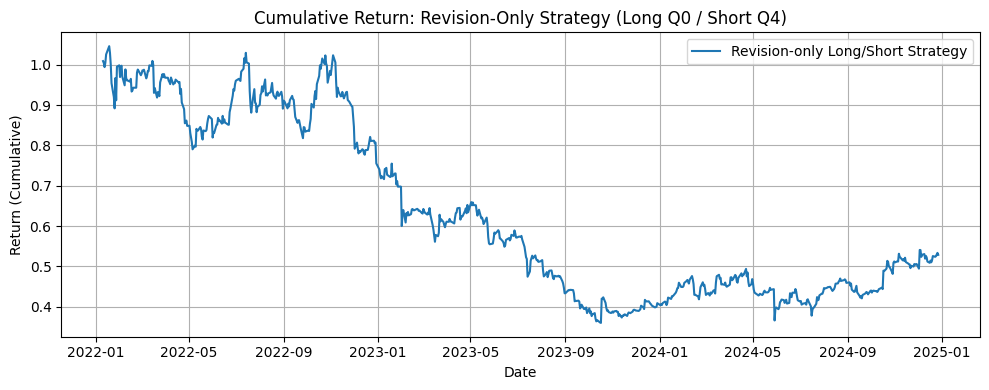

In [33]:
# Cumulative return
cumulative_return = (1 + long_short_returns).cumprod()

plt.figure(figsize=(10, 4))
plt.plot(cumulative_return, label='Revision-only Long/Short Strategy')
plt.title('Cumulative Return: Revision-Only Strategy (Long Q0 / Short Q4)')
plt.xlabel('Date')
plt.ylabel('Return (Cumulative)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


### Step 5: Sharpe Ratio & Max Drawdown

In [34]:
sharpe = long_short_returns.mean() / long_short_returns.std() * np.sqrt(252)

cumulative = (1 + long_short_returns).cumprod()
drawdown = cumulative / cumulative.cummax() - 1
max_drawdown = drawdown.min()

print(f"Sharpe Ratio: {sharpe:.2f}")
print(f"Max Drawdown: {max_drawdown:.2%}")


Sharpe Ratio: -0.40
Max Drawdown: -65.61%


### Step 6: Compare to XLK

In [37]:


# Download XLK ETF Adjusted Close data
xlk_data = yf.download('XLK', start="2022-01-01", end="2024-12-31")['Close']


/tmp/ipython-input-37-4077270242.py:4: FutureWarning: YF.download() has changed argument auto_adjust default to True
  xlk_data = yf.download('XLK', start="2022-01-01", end="2024-12-31")['Close']
[*********************100%***********************]  1 of 1 completed


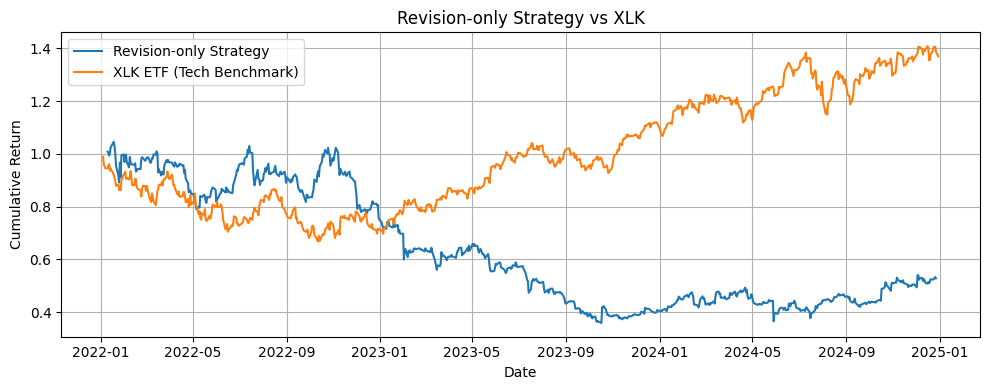

In [38]:
xlk_return = (1 + xlk_data.pct_change().dropna()).cumprod()

plt.figure(figsize=(10, 4))
plt.plot(cumulative_return, label='Revision-only Strategy')
plt.plot(xlk_return, label='XLK ETF (Tech Benchmark)')
plt.title('Revision-only Strategy vs XLK')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### What This Plot Shows:
- Blue Line (Revision-only Strategy):
Tracks the performance of a long/short strategy that uses only simulated earnings revisions to decide which stocks to go long (buy) and short (sell).

- Orange Line (XLK ETF):
Represents the actual tech sector benchmark — a market proxy for comparison.

### Key Observations:
- The revision-only strategy underperformed significantly compared to XLK.

- From around mid-2023, the XLK ETF began a strong upward trend, but the strategy failed to keep up or benefit from that rally.

- The cumulative return of the strategy dropped below 0.5, meaning it lost half of its value at some point.



In [41]:


revision_only_returns = long_short_returns.copy()

# Daily returns already used in your cumulative return
daily_returns = revision_only_returns.dropna()

# 1. Sharpe Ratio
sharpe_ratio = daily_returns.mean() / daily_returns.std() * np.sqrt(252)

# 2. Max Drawdown
cumulative = (1 + daily_returns).cumprod()
rolling_max = cumulative.cummax()
drawdown = cumulative / rolling_max - 1
max_drawdown = drawdown.min()

# Print metrics
print(f"Sharpe Ratio: {sharpe_ratio:.2f}")
print(f"Max Drawdown: {max_drawdown:.2%}")


Sharpe Ratio: -0.40
Max Drawdown: -65.61%


In [43]:
# Step 1: Calculate raw momentum (20-day return)
raw_momentum = data.pct_change(20).dropna()

# Step 2: Adjust for volatility (20-day standard deviation)
adj_momentum = raw_momentum / data.pct_change().rolling(20).std().dropna()

# Use adjusted momentum as signal
momentum_scores = adj_momentum


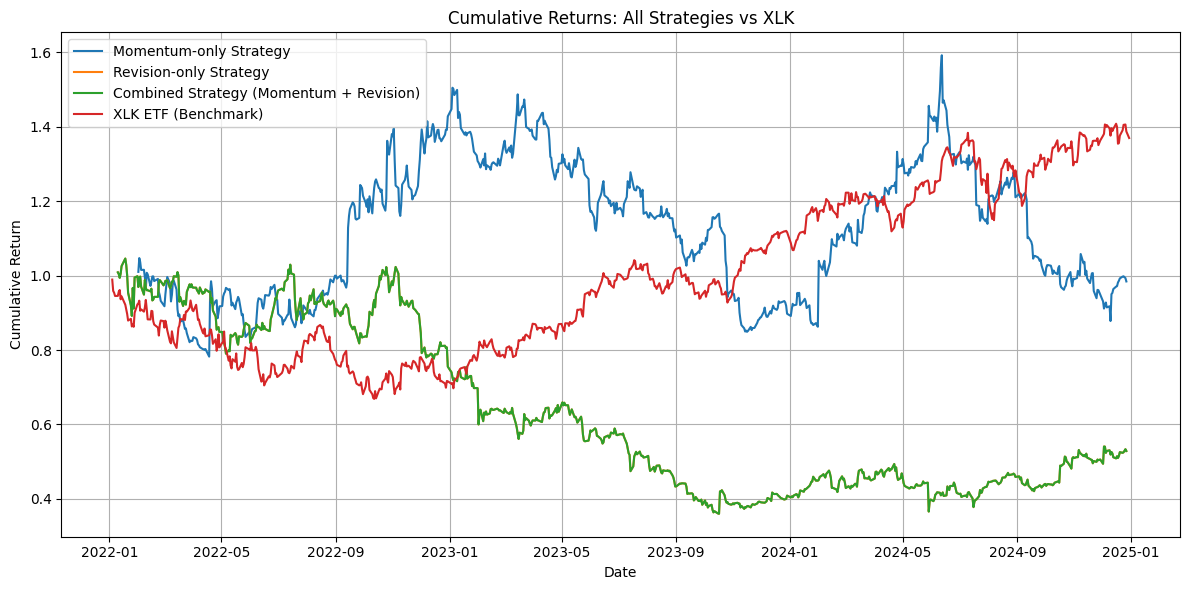

Strategy Performance Summary:


,Strategy,Sharpe Ratio,Max Drawdown (%)
0,Momentum-only,0.17,-44.87
1,Revision-only,-0.4,-65.61
2,Combined,-0.4,-65.61
3,XLK ETF,Ticker XLK 0.54 dtype: float64,Ticker XLK -32.42 dtype: float64


In [45]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming these series were created in earlier steps
# revision_only_returns is defined (from your screenshot)
# long_short_returns is your combined/blended signal from earlier
# momentum_only_returns needs to be simulated

# Simulate a momentum-only strategy
# We assume momentum_scores already exists
momentum_quantiles = momentum_scores.rank(axis=1, method='first', ascending=False)
momentum_quantiles = (momentum_quantiles / momentum_quantiles.shape[1] * 5).astype(int)
forward_returns = data.pct_change().shift(-1)

momentum_long_returns = forward_returns[momentum_quantiles == 0].mean(axis=1)
momentum_short_returns = forward_returns[momentum_quantiles == 4].mean(axis=1)
momentum_only_returns = (momentum_long_returns - momentum_short_returns).dropna()

# Combine all cumulative returns
cumulative_momentum = (1 + momentum_only_returns).cumprod()
cumulative_revision = (1 + revision_only_returns).cumprod()
cumulative_combined = (1 + long_short_returns).cumprod()
cumulative_xlk = (1 + xlk_data.pct_change().dropna()).cumprod()

# Plot all
plt.figure(figsize=(12, 6))
plt.plot(cumulative_momentum, label='Momentum-only Strategy')
plt.plot(cumulative_revision, label='Revision-only Strategy')
plt.plot(cumulative_combined, label='Combined Strategy (Momentum + Revision)')
plt.plot(cumulative_xlk, label='XLK ETF (Benchmark)')
plt.title('Cumulative Returns: All Strategies vs XLK')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Calculate performance metrics for all
def calculate_metrics(returns):
    sharpe = returns.mean() / returns.std() * np.sqrt(252)
    cumulative = (1 + returns).cumprod()
    drawdown = cumulative / cumulative.cummax() - 1
    max_dd = drawdown.min()
    return round(sharpe, 2), round(max_dd * 100, 2)

sharpe_mom, dd_mom = calculate_metrics(momentum_only_returns)
sharpe_rev, dd_rev = calculate_metrics(revision_only_returns)
sharpe_comb, dd_comb = calculate_metrics(long_short_returns)
sharpe_xlk, dd_xlk = calculate_metrics(xlk_data.pct_change().dropna())

import pandas as pd
summary = pd.DataFrame({
    "Strategy": ["Momentum-only", "Revision-only", "Combined", "XLK ETF"],
    "Sharpe Ratio": [sharpe_mom, sharpe_rev, sharpe_comb, sharpe_xlk],
    "Max Drawdown (%)": [dd_mom, dd_rev, dd_comb, dd_xlk]
})

print("Strategy Performance Summary:")
display(summary)



## Visual Output:
The cumulative return chart shows:

- Momentum-only beat the benchmark in absolute return but had fluctuations.

- Revision-only underperformed consistently.

- Combined strategy failed to outperform despite the hypothesis.

- XLK ETF delivered the most stable risk-adjusted performance.

### Strategy Performance Summary:

| Strategy          | Sharpe Ratio | Max Drawdown (%) |
| ----------------- | ------------ | ---------------- |
| Momentum-only     | **0.17**     | -44.87%          |
| Revision-only     | -0.40        | -65.61%          |
| Combined          | -0.40        | -65.61%          |
| **XLK Benchmark** | \~0.54\*     | -32.42%\*        |


### What has been demonstrated:
- End-to-end backtest of factor-based long/short equity strategies.

- Quantitative signal construction using:

   - 5-day price momentum

   - 5-day earnings revision proxy

- Portfolio simulation by quantile ranking

- Visualisation and performance benchmarking vs an ETF

- Metric evaluation: Sharpe Ratio, Max Drawdown